In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customers/extract - fees - data analyst - .csv
/kaggle/input/bank-customers/extract - cash request - data analyst.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
fees = pd.read_csv('/kaggle/input/bank-customers/extract - fees - data analyst - .csv')
cash_request = pd.read_csv('/kaggle/input/bank-customers/extract - cash request - data analyst.csv')

In [4]:
merged_df = fees.merge(
    cash_request, left_on="cash_request_id", right_on="id", suffixes=("_fees", "_cash")
)

In [5]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21057 entries, 0 to 21056
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_fees                     21057 non-null  int64  
 1   cash_request_id             21057 non-null  float64
 2   type                        21057 non-null  object 
 3   status_fees                 21057 non-null  object 
 4   category                    2196 non-null   object 
 5   total_amount                21057 non-null  float64
 6   reason                      21057 non-null  object 
 7   created_at_fees             21057 non-null  object 
 8   updated_at_fees             21057 non-null  object 
 9   paid_at                     15531 non-null  object 
 10  from_date                   7766 non-null   object 
 11  to_date                     7766 non-null   object 
 12  charge_moment               21057 non-null  object 
 13  id_cash                     210

In [27]:
# create a categorical field for the 
merged_df['fees_rejeted'] = merged_df.groupby('cash_request_id')['category'].count()
merged_df['fees_rejeted']= merged_df['fees_rejeted'].fillna(0)
merged_df['fees_rejeted']=merged_df['fees_rejeted'].sort_values()
merged_df['fees_rejeted'].unique()
bins = [0 ,2, 5]
labels =['Low' , 'High']
merged_df['fees_rejection_segment'] = pd.cut(merged_df['fees_rejeted'] , bins = bins , labels = labels, include_lowest = True  )

0        Low
1        Low
2        Low
3        Low
4        Low
        ... 
21052    Low
21053    Low
21054    Low
21055    Low
21056    Low
Name: fees_rejection_segment, Length: 21057, dtype: category
Categories (2, object): ['Low' < 'High']

In [28]:
# Filter dataset to only work on the paid credits to find anomalies
merged_df = merged_df[~merged_df['status_cash'].isin(['cancelled', 'rejected'])]

In [29]:
# Create a new feature: repayment delay in days
merged_df['money_back_date'] = pd.to_datetime(merged_df['money_back_date'], errors='coerce')
merged_df["reimbursement_date"] = pd.to_datetime(merged_df["reimbursement_date"], errors='coerce')
merged_df["repayment_delay"] = (merged_df["money_back_date"] - merged_df["reimbursement_date"]).dt.days

In [30]:
# Define segmentation based on repayment behavior
def categorize_repayment(row):
    '''
         "Defaulter" refers to a customer who has not repaid the money at all
         "Late Payer" refers to a customer who returned the money after the expected reimbursement date.
    '''
    if pd.isna(row["money_back_date"]):
        return "Defaulter"
    elif row["money_back_date"] <= row["reimbursement_date"]:
        return "On-time Payer"
    else:
        return "Late Payer"

In [32]:
merged_df["Repayment_Status"] = merged_df.apply(categorize_repayment, axis=1)

array(['Late Payer', 'Defaulter', 'On-time Payer'], dtype=object)

### I should Think about this part. 
# What is the best value to fill null values with?

In [34]:
# Set the repayment_delay to -1 when we couldn't calculate it. 
merged_df["repayment_delay"].fillna(90, inplace=True)

date_cols = ["reimbursement_date", "paid_at" ,"created_at_fees", "cash_request_received_date" , "money_back_date" , "send_at", "reco_creation","reco_last_update"]
for col in date_cols:
    merged_df[col] = pd.to_datetime(merged_df[col], errors='coerce')
    merged_df[col]= merged_df[col].dt.tz_localize(None)
    merged_df[str(col)+'_Month']= merged_df[col].dt.to_period('M')
    merged_df=merged_df.drop(columns=[col])

merged_df.describe()

,id_fees,cash_request_id,total_amount,id_cash,amount,user_id,deleted_account_id,fees_rejeted,repayment_delay
count,21057.000000,21057.000000,21057.000000,21057.000000,21057.000000,20151.000000,906.000000,21057.000000,21057.000000
mean,10646.670228,16318.449162,5.000237,16318.449162,81.833547,37988.603940,17334.621413,0.104051,73.607162
std,6099.136169,6656.149949,0.034457,6656.149949,26.945058,27987.123692,7315.152519,0.422185,33.706038
min,1.000000,1456.000000,5.000000,1456.000000,1.000000,47.000000,3857.000000,0.000000,-69.000000
25%,5388.000000,11745.000000,5.000000,11745.000000,50.000000,14868.000000,11051.000000,0.000000,90.000000
50%,10654.000000,17160.000000,5.000000,17160.000000,100.000000,31538.000000,19717.000000,0.000000,90.000000
75%,15926.000000,21796.000000,5.000000,21796.000000,100.000000,56357.500000,23322.000000,0.000000,90.000000
max,21193.000000,27010.000000,10.000000,27010.000000,200.000000,103503.000000,30445.000000,5.000000,161.000000


In [35]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21057 entries, 0 to 21056
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype    
---  ------                            --------------  -----    
 0   id_fees                           21057 non-null  int64    
 1   cash_request_id                   21057 non-null  float64  
 2   type                              21057 non-null  object   
 3   status_fees                       21057 non-null  object   
 4   category                          2196 non-null   object   
 5   total_amount                      21057 non-null  float64  
 6   reason                            21057 non-null  object   
 7   updated_at_fees                   21057 non-null  object   
 8   from_date                         7766 non-null   object   
 9   to_date                           7766 non-null   object   
 10  charge_moment                     21057 non-null  object   
 11  id_cash                           21057 n

## Time Trends Based on Transaction type

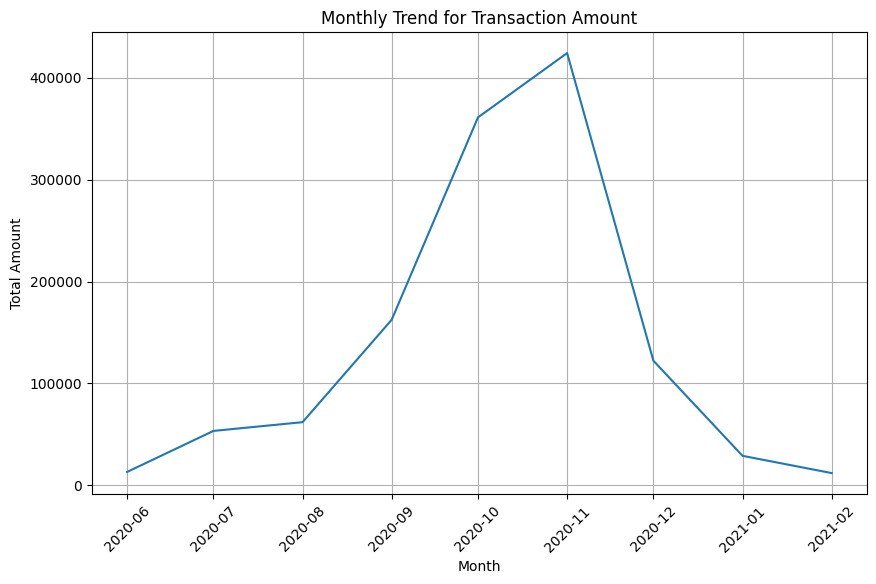

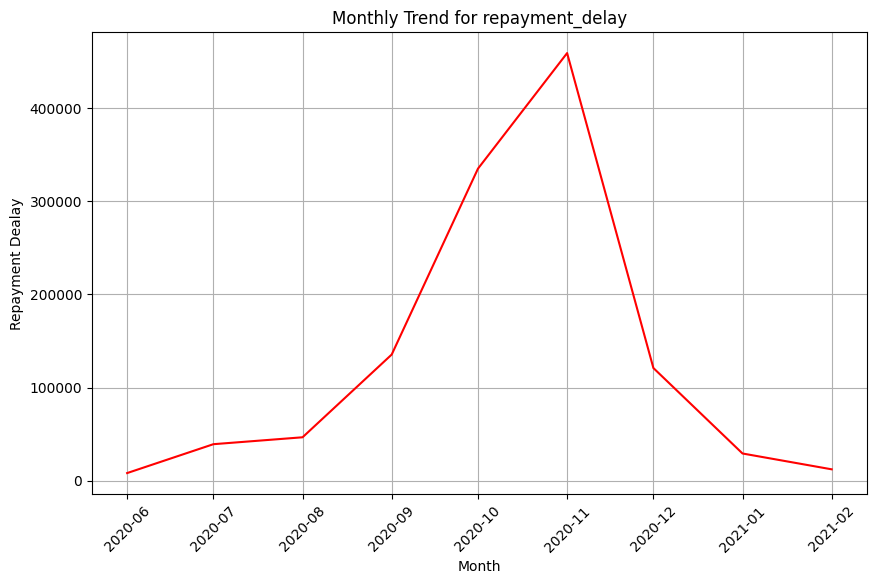

In [12]:
monthly_trend_for_transactions=merged_df.groupby( ['paid_at_Month'])[['amount', 'repayment_delay']].sum().reset_index()

monthly_trend_for_transactions['paid_at_Month'] = monthly_trend_for_transactions['paid_at_Month'].dt.to_timestamp()
monthly_trend_for_transactions = monthly_trend_for_transactions.sort_values(by='paid_at_Month')


plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_trend_for_transactions, x='paid_at_Month', y='amount')

plt.title('Monthly Trend for Transaction Amount')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_trend_for_transactions, x='paid_at_Month', y='repayment_delay' , color='red')

plt.title('Monthly Trend for repayment_delay')
plt.xlabel('Month')
plt.ylabel('Repayment Dealay')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

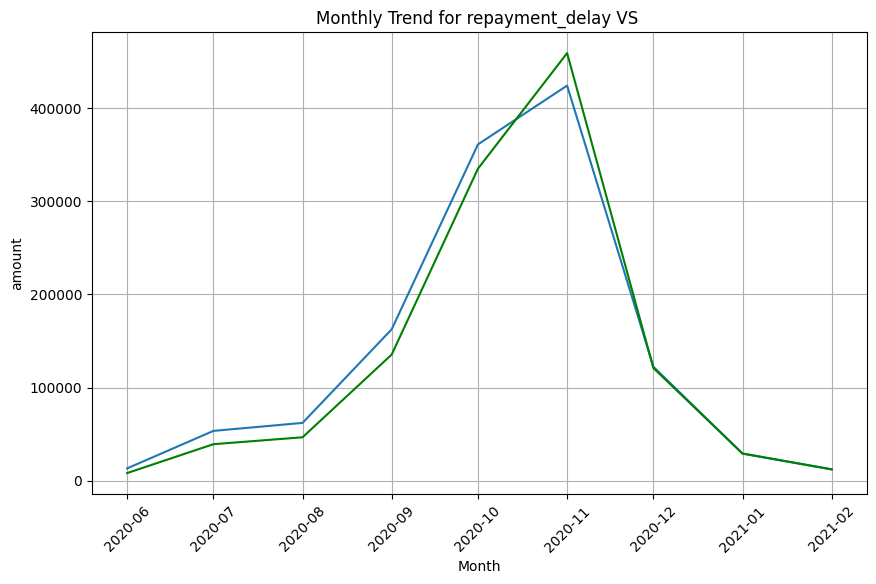

In [14]:
monthly_trend_for_repayment_delay=merged_df.groupby( ['paid_at_Month'])['repayment_delay'].sum().reset_index()

monthly_trend_for_repayment_delay['paid_at_Month'] = monthly_trend_for_repayment_delay['paid_at_Month'].dt.to_timestamp()
monthly_trend_for_repayment_delay = monthly_trend_for_repayment_delay.sort_values(by='paid_at_Month')

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_trend_for_transactions, x='paid_at_Month', y='amount')
sns.lineplot(data=monthly_trend_for_repayment_delay, x='paid_at_Month', y='repayment_delay' , color='green')

plt.title('Monthly Trend for repayment_delay VS ')
plt.xlabel('Month')
# plt.ylabel()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

In [15]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21057 entries, 0 to 21056
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype    
---  ------                            --------------  -----    
 0   id_fees                           21057 non-null  int64    
 1   cash_request_id                   21057 non-null  float64  
 2   type                              21057 non-null  object   
 3   status_fees                       21057 non-null  object   
 4   category                          2196 non-null   object   
 5   total_amount                      21057 non-null  float64  
 6   reason                            21057 non-null  object   
 7   updated_at_fees                   21057 non-null  object   
 8   from_date                         7766 non-null   object   
 9   to_date                           7766 non-null   object   
 10  charge_moment                     21057 non-null  object   
 11  id_cash                           21057 n

In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
# Select features for anomaly detection
label_encoder = LabelEncoder()
merged_df['type_encoded']= label_encoder.fit_transform(merged_df['type'])
merged_df['fees_rejection_segment_encoded'] = label_encoder.fit_transform(merged_df['fees_rejection_segment'])
merged_df['transfer_type_encoded']= label_encoder.fit_transform(merged_df['transfer_type'])
merged_df['status_fees_encoded']= label_encoder.fit_transform(merged_df['status_fees'])
features = ['total_amount', 'amount', 'repayment_delay' , 'type_encoded' , 'transfer_type_encoded' , 'status_fees_encoded', 'fees_rejection_segment_encoded']
merged_df.dropna(subset=features, inplace=True)
X = merged_df[features]

# Train Isolation Forest for anomaly detection
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
merged_df["Anomaly_Score"] = iso_forest.fit_predict(X)

# Label anomalies (-1 means an anomaly)
merged_df["Anomaly"] = merged_df["Anomaly_Score"].apply(lambda x: "Anomalous" if x == -1 else "Normal")

# Display the segmented data with anomaly detection
merged_df.head()

,id_fees,cash_request_id,type,status_fees,category,total_amount,reason,updated_at_fees,from_date,to_date,...,money_back_date_Month,send_at_Month,reco_creation_Month,reco_last_update_Month,type_encoded,fees_rejection_segment_encoded,transfer_type_encoded,status_fees_encoded,Anomaly_Score,Anomaly
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-10-13 14:25:09.396112+00,NaN,NaN,...,2020-10,2020-09,2020-10,2020-12,1,1,0,3,-1,Anomalous
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-10-13 14:25:15.537063+00,NaN,NaN,...,NaT,2020-08,2020-09,2020-10,0,1,0,0,1,Normal
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352994+00,NaN,NaN,...,NaT,2020-10,NaT,NaT,1,1,0,0,1,Normal
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643982+00,NaN,NaN,...,2020-11,2020-10,NaT,NaT,1,1,0,0,1,Normal
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-13 14:25:03.267983+00,NaN,NaN,...,NaT,2020-10,2020-10,2020-11,1,1,0,0,1,Normal


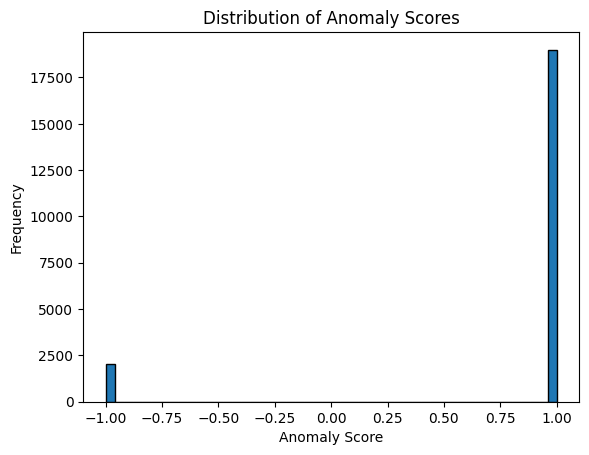

In [37]:
import matplotlib.pyplot as plt

plt.hist(merged_df["Anomaly_Score"], bins=50, edgecolor='black')
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores")
plt.show()

In [38]:
print(merged_df["Anomaly"].value_counts(normalize=True) * 100)

Anomaly
Normal       90.221779
Anomalous     9.778221
Name: proportion, dtype: float64


In [39]:
anomalies = merged_df[merged_df["Anomaly"] == "Anomalous"]
anomalies[["cash_request_id", "total_amount", "repayment_delay", "Repayment_Status", "status_fees" , 'fees_rejection_segment']]


,cash_request_id,total_amount,repayment_delay,Repayment_Status,status_fees,fees_rejection_segment
0,14941.0,5.0,5.0,Late Payer,rejected,Low
27,10287.0,5.0,90.0,Defaulter,rejected,Low
42,25769.0,5.0,90.0,Defaulter,rejected,Low
43,19981.0,5.0,90.0,Defaulter,rejected,Low
47,9338.0,5.0,90.0,Late Payer,accepted,Low
...,...,...,...,...,...,...
21049,17642.0,5.0,90.0,Defaulter,rejected,Low
21052,20262.0,5.0,6.0,Late Payer,rejected,Low
21053,26764.0,5.0,90.0,Defaulter,rejected,Low
21054,25331.0,5.0,90.0,Defaulter,rejected,Low


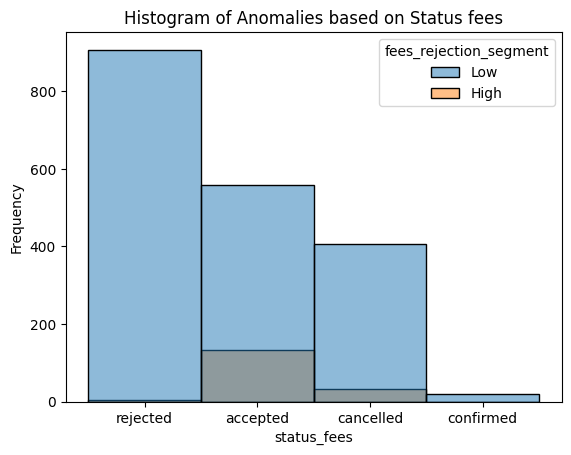

In [41]:
import seaborn as sns
sns.histplot(anomalies , x='status_fees', bins =10 , hue='fees_rejection_segment')
plt.title('Histogram of Anomalies based on Status fees')
plt.ylabel('Frequency')
plt.show()

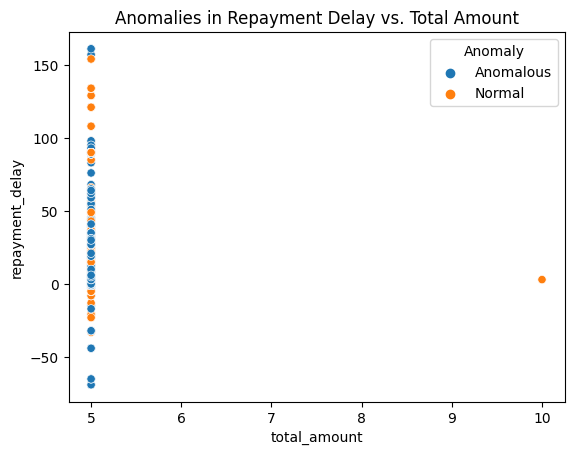

In [42]:
sns.scatterplot(data=merged_df, x="total_amount", y="repayment_delay", hue="Anomaly")
plt.title("Anomalies in Repayment Delay vs. Total Amount")
plt.show()

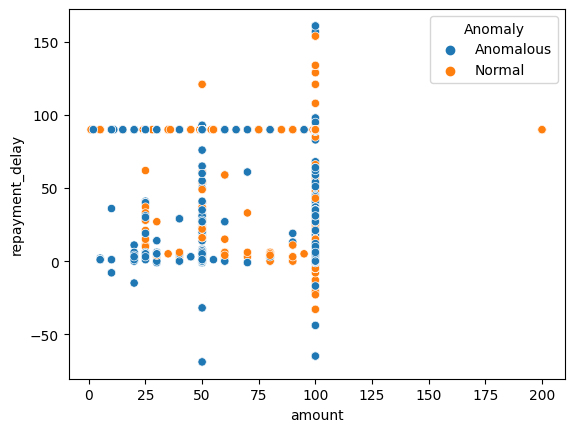

In [44]:
sns.scatterplot(data=merged_df, x="amount", y="repayment_delay", hue="Anomaly")
plt.show()

In [46]:
max_repayment_delay= merged_df['repayment_delay'].max()

161.0

In [47]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
merged_df["LOF_Anomaly_Score"] = lof.fit_predict(X)

print(merged_df["LOF_Anomaly_Score"].value_counts())  # Compare with Isolation Forest results

LOF_Anomaly_Score
 1    19468
-1     1589
Name: count, dtype: int64


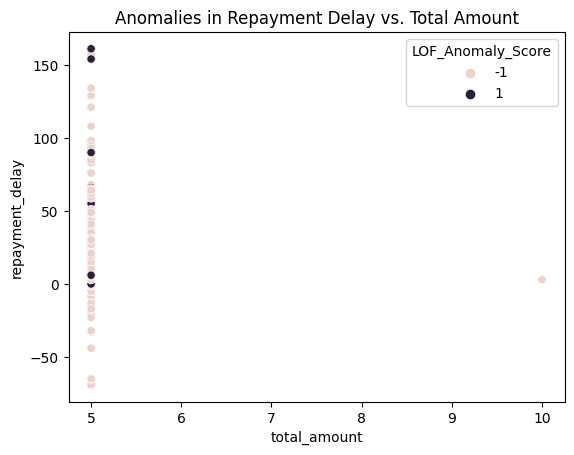

In [48]:
sns.scatterplot(data=merged_df, x="total_amount", y="repayment_delay", hue="LOF_Anomaly_Score")
plt.title("Anomalies in Repayment Delay vs. Total Amount")
plt.show()

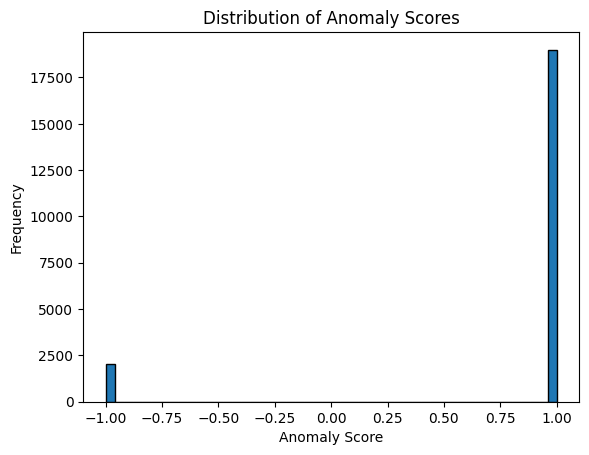

In [49]:
import matplotlib.pyplot as plt

plt.hist(merged_df["Anomaly_Score"], bins=50, edgecolor='black')
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores")
plt.show()

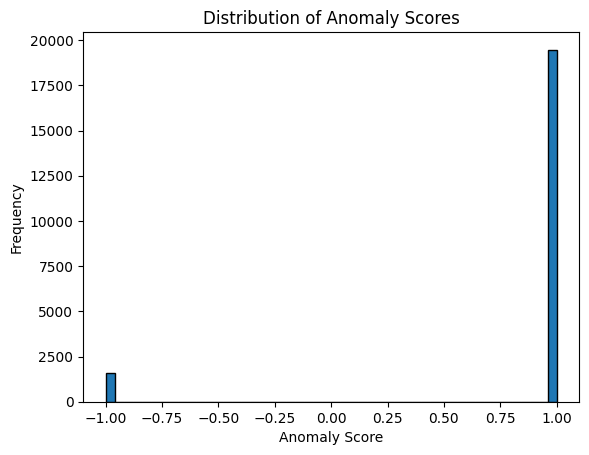

In [50]:
plt.hist(merged_df["LOF_Anomaly_Score"], bins=50, edgecolor='black')
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores")
plt.show()

In [51]:
print(merged_df[["Anomaly_Score", "LOF_Anomaly_Score"]].value_counts())

Anomaly_Score  LOF_Anomaly_Score
 1              1                   18190
-1              1                    1278
 1             -1                     808
-1             -1                     781
Name: count, dtype: int64


In [52]:
# Combine results from both algorithms
merged_df["Combined_Anomaly"] = (
    (merged_df["Anomaly_Score"] == -1) | (merged_df["LOF_Anomaly_Score"] == -1)
)

# Count combined anomalies
print(merged_df["Combined_Anomaly"].value_counts())

Combined_Anomaly
False    18190
True      2867
Name: count, dtype: int64


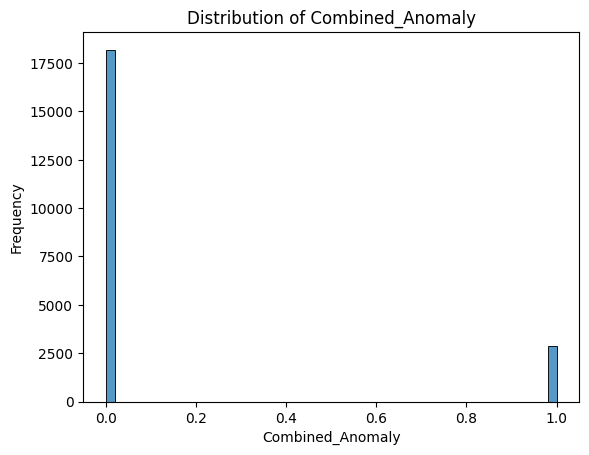

In [53]:
sns.histplot(merged_df["Combined_Anomaly"], bins=50, edgecolor='black')
plt.xlabel("Combined_Anomaly")
plt.ylabel("Frequency")
plt.title("Distribution of Combined_Anomaly")
plt.show()

In [54]:
print(merged_df["Combined_Anomaly"].value_counts(normalize=True) * 100)

Combined_Anomaly
False    86.384575
True     13.615425
Name: proportion, dtype: float64


In [56]:
anomalies = merged_df[merged_df["Combined_Anomaly"] == True]
print(anomalies[['user_id' ,'cash_request_id', 'total_amount', 'repayment_delay', 'Repayment_Status' , 'fees_rejection_segment']].head(50))

      user_id  cash_request_id  total_amount  repayment_delay  \
0     35661.0          14941.0           5.0              5.0   
27    12710.0          10287.0           5.0             90.0   
42    37011.0          25769.0           5.0             90.0   
43    64641.0          19981.0           5.0             90.0   
44     2142.0          12952.0           5.0             90.0   
47    33061.0           9338.0           5.0             90.0   
55    97197.0          26575.0           5.0             36.0   
70    29796.0          22977.0           5.0             15.0   
79    96086.0          26494.0           5.0              4.0   
87    32586.0          16534.0           5.0             90.0   
94    37157.0          14814.0           5.0             28.0   
106       NaN          14924.0           5.0             31.0   
110   22660.0           7222.0           5.0             90.0   
115   35676.0          14093.0           5.0             90.0   
143   14384.0           3

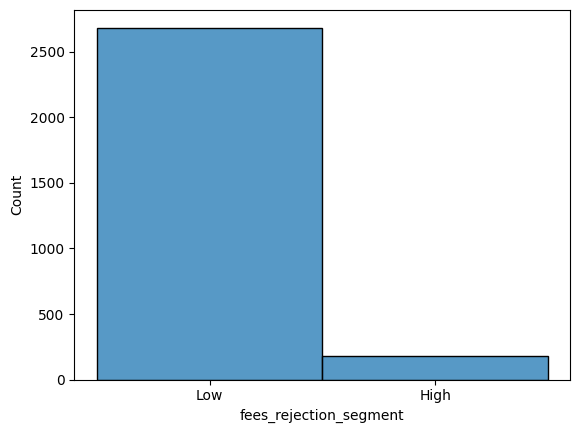

In [58]:
sns.histplot(anomalies , x='fees_rejection_segment')
plt.show()

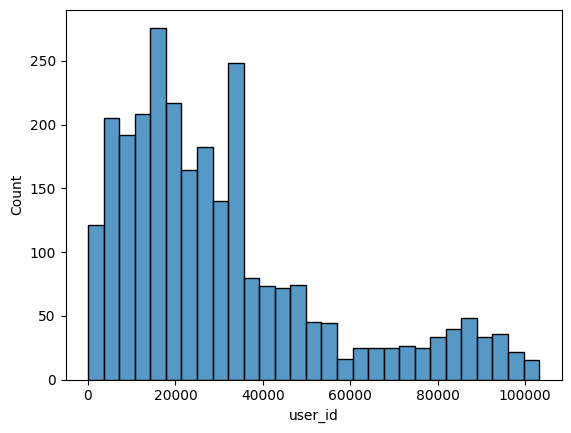

In [59]:
sns.histplot(anomalies , x='user_id')
plt.show()

<Axes: xlabel='Repayment_Status', ylabel='Count'>

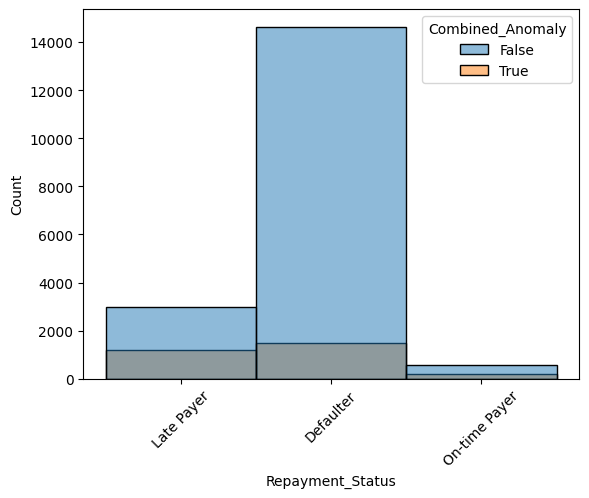

In [60]:
plt.xticks(rotation=45)
sns.histplot(data=merged_df , x='Repayment_Status' , hue='Combined_Anomaly')

        user_id  cash_request_id  total_amount  Combined_Anomaly
0       35661.0          14941.0           5.0              True
27      12710.0          10287.0           5.0              True
42      37011.0          25769.0           5.0              True
43      64641.0          19981.0           5.0              True
44       2142.0          12952.0           5.0              True
...         ...              ...           ...               ...
21049   48059.0          17642.0           5.0              True
21052   64923.0          20262.0           5.0              True
21053  100564.0          26764.0           5.0              True
21054   70754.0          25331.0           5.0              True
21055   72437.0          23628.0           5.0              True

[2867 rows x 4 columns]


<Axes: xlabel='total_amount', ylabel='Count'>

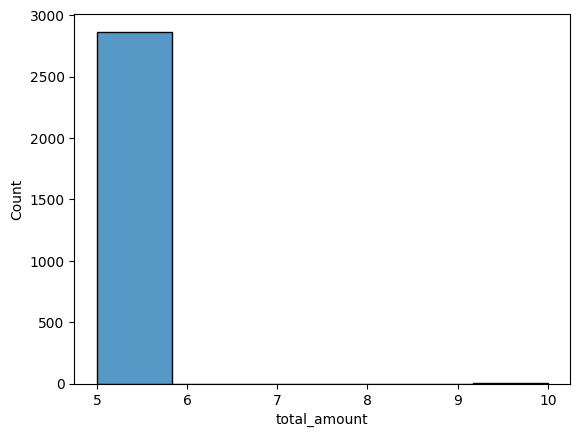

In [61]:
anomal_data = merged_df[merged_df['Combined_Anomaly']== True]
print(anomal_data[['user_id','cash_request_id','total_amount', 'Combined_Anomaly']])
sns.histplot(data=anomal_data, x='total_amount', bins=6)

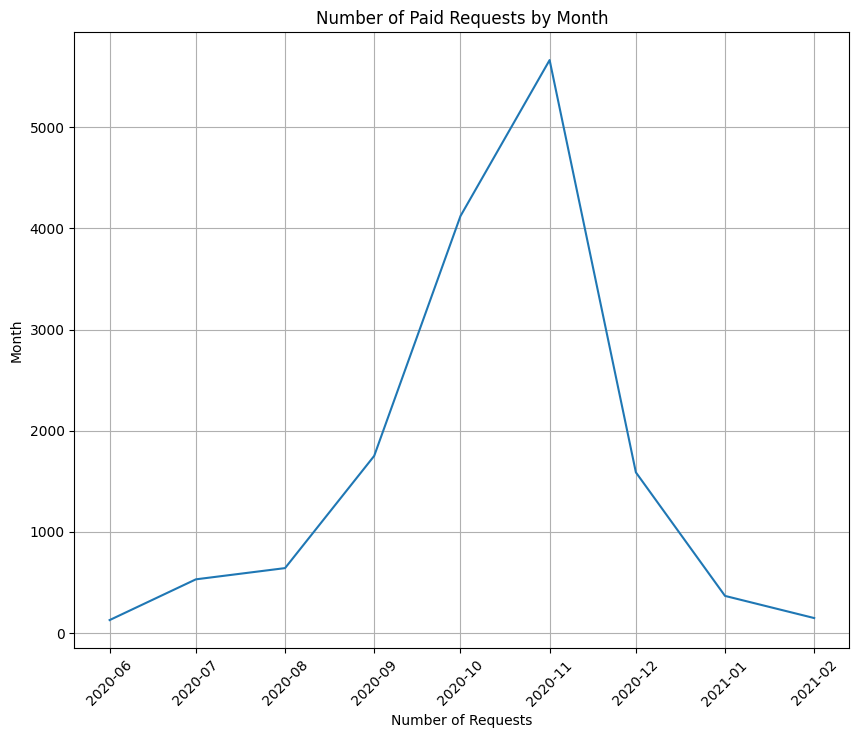

In [62]:
paid_count_per_month = merged_df.groupby('paid_at_Month')['user_id'].count().reset_index()
paid_count_per_month['paid_at_Month'] = paid_count_per_month['paid_at_Month'].dt.to_timestamp()
plt.figure(figsize=(10,8))
plt.xticks(rotation=45)
sns.lineplot(data=paid_count_per_month , y='user_id' , x='paid_at_Month' )
plt.title('Number of Paid Requests by Month')
plt.xlabel('Number of Requests')
plt.ylabel('Month')
plt.grid()
plt.show()


In [63]:
# distribution of Anomalies over other features
features = merged_df.describe().columns

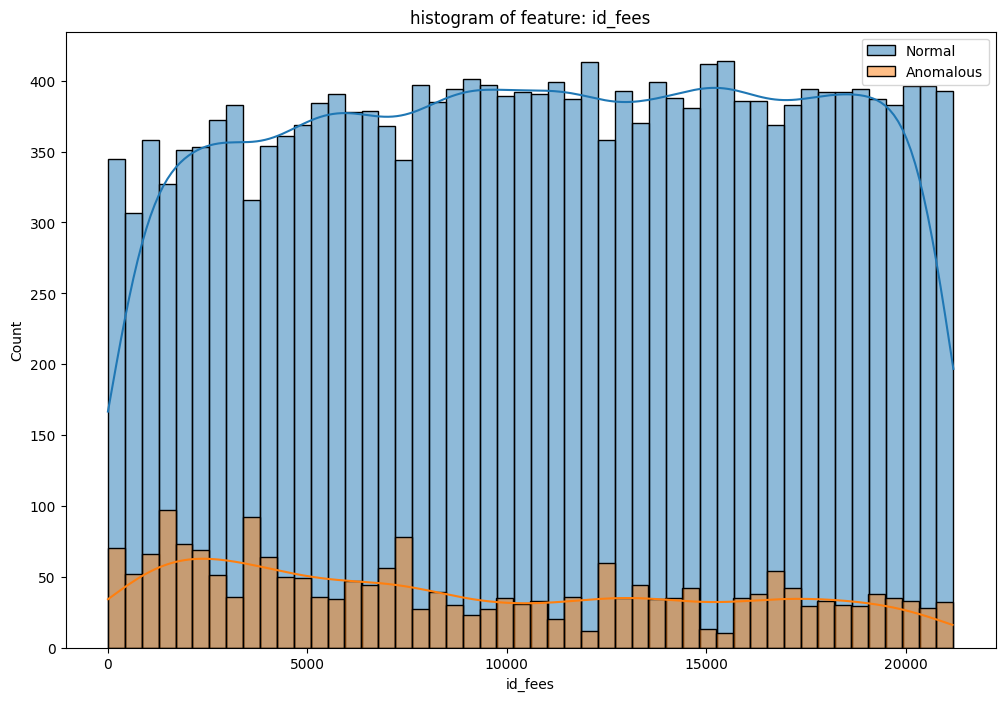

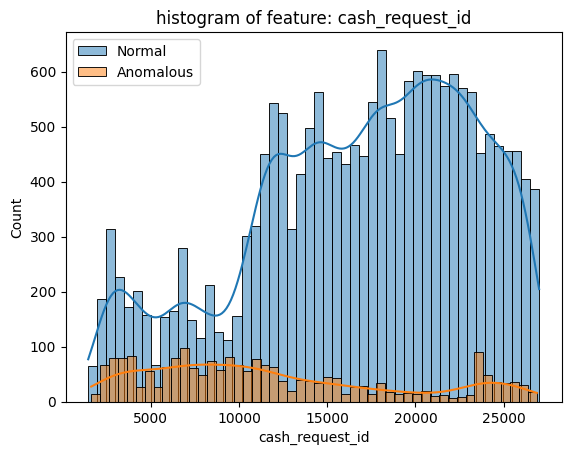

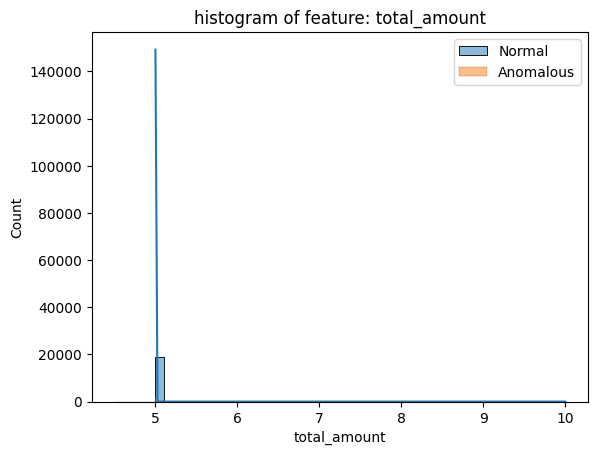

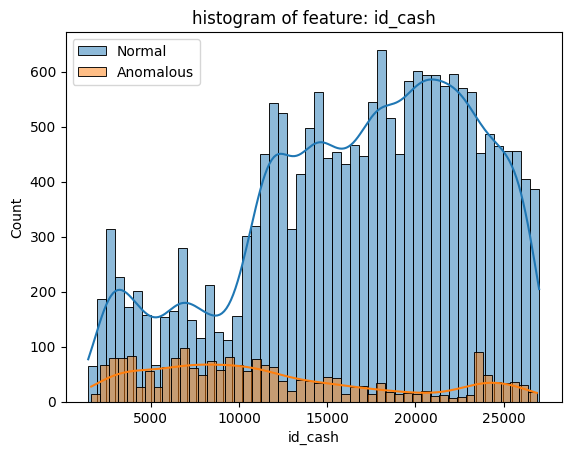

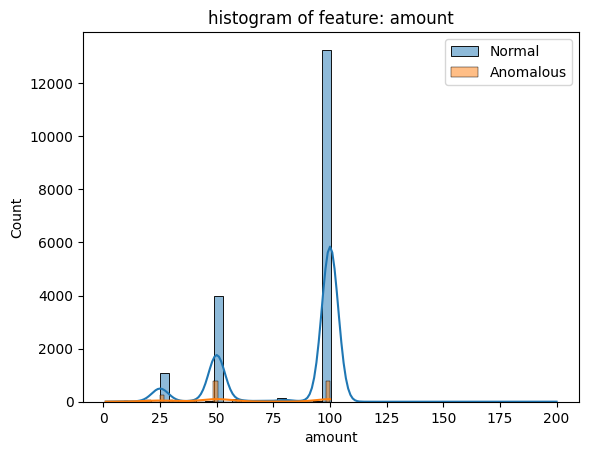

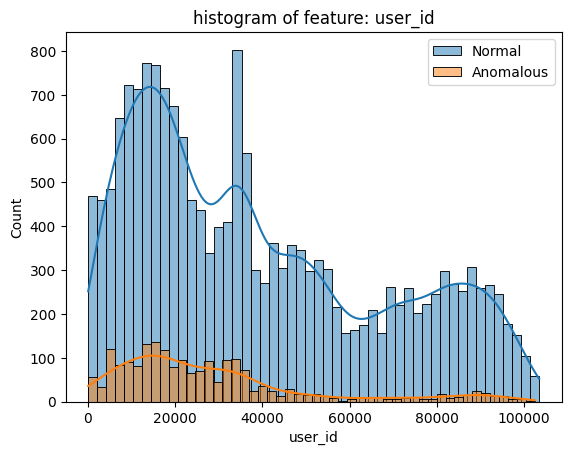

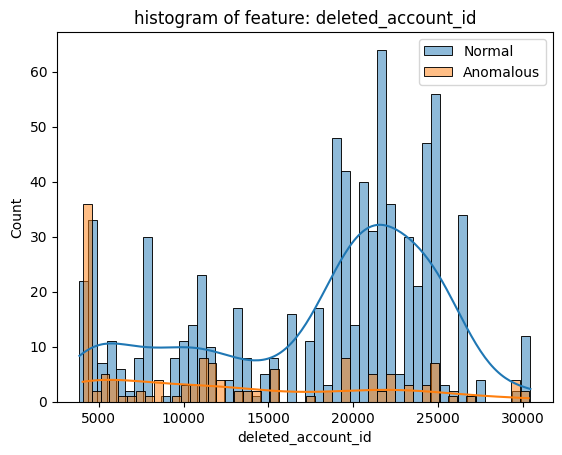

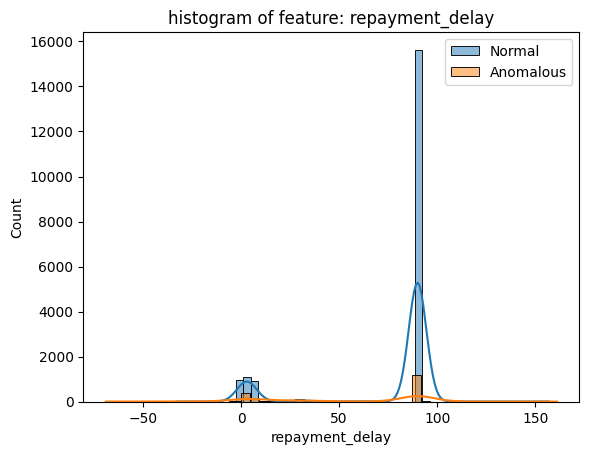

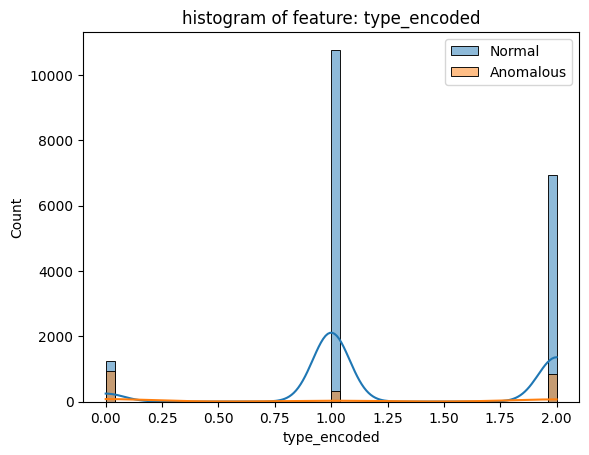

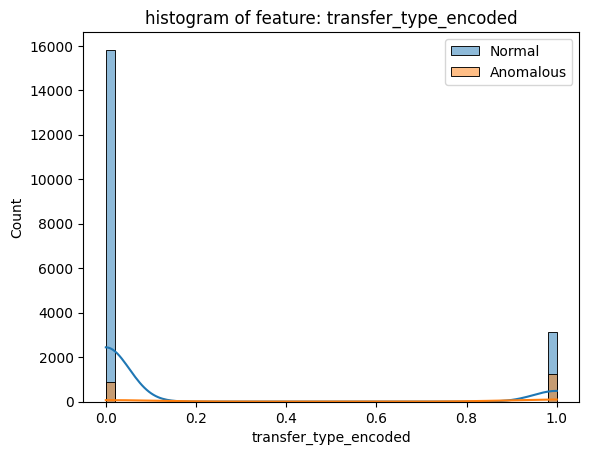

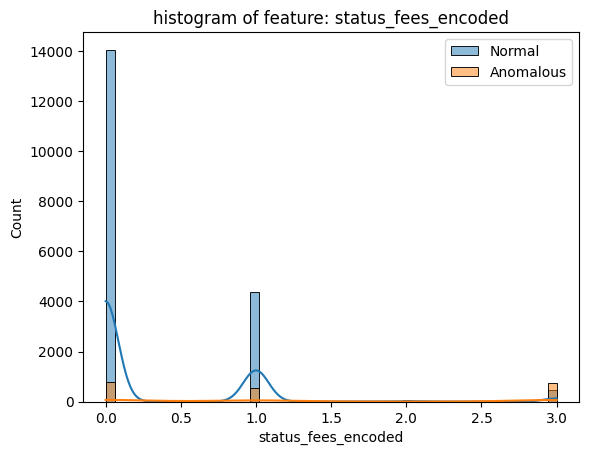

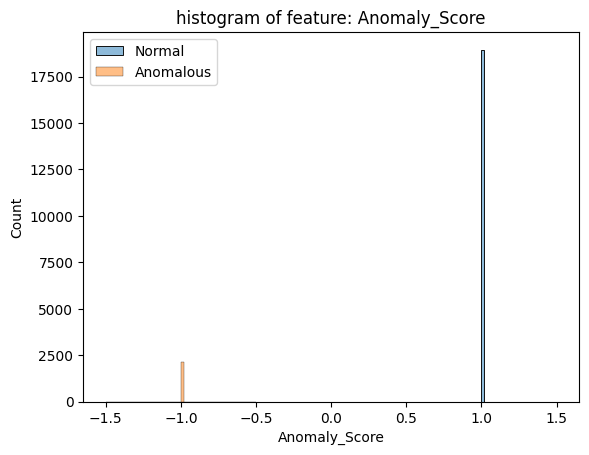

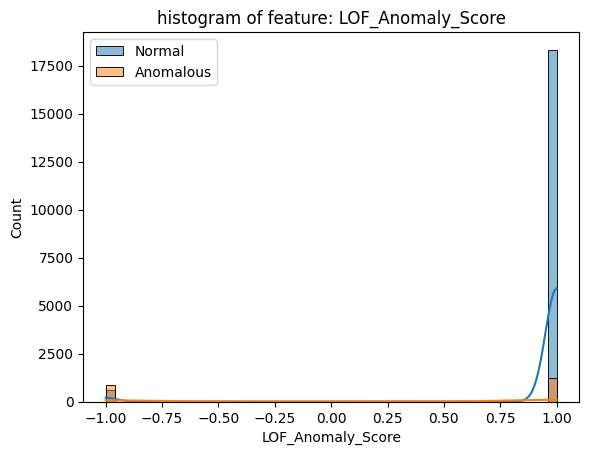

In [62]:
plt.figure(figsize=(12,8))

for feature in features:
    sns.histplot(merged_df[feature][merged_df.Anomaly_Score == 1], bins=50, kde=True, label="Normal")
    sns.histplot(merged_df[feature][merged_df.Anomaly_Score == -1], bins=50, kde=True, label="Anomalous")
    plt.title('histogram of feature: ' + str(feature))
    plt.legend()
    plt.show()


Total amount has value and there is no Null value it this column, but it still dosen't show the relation 

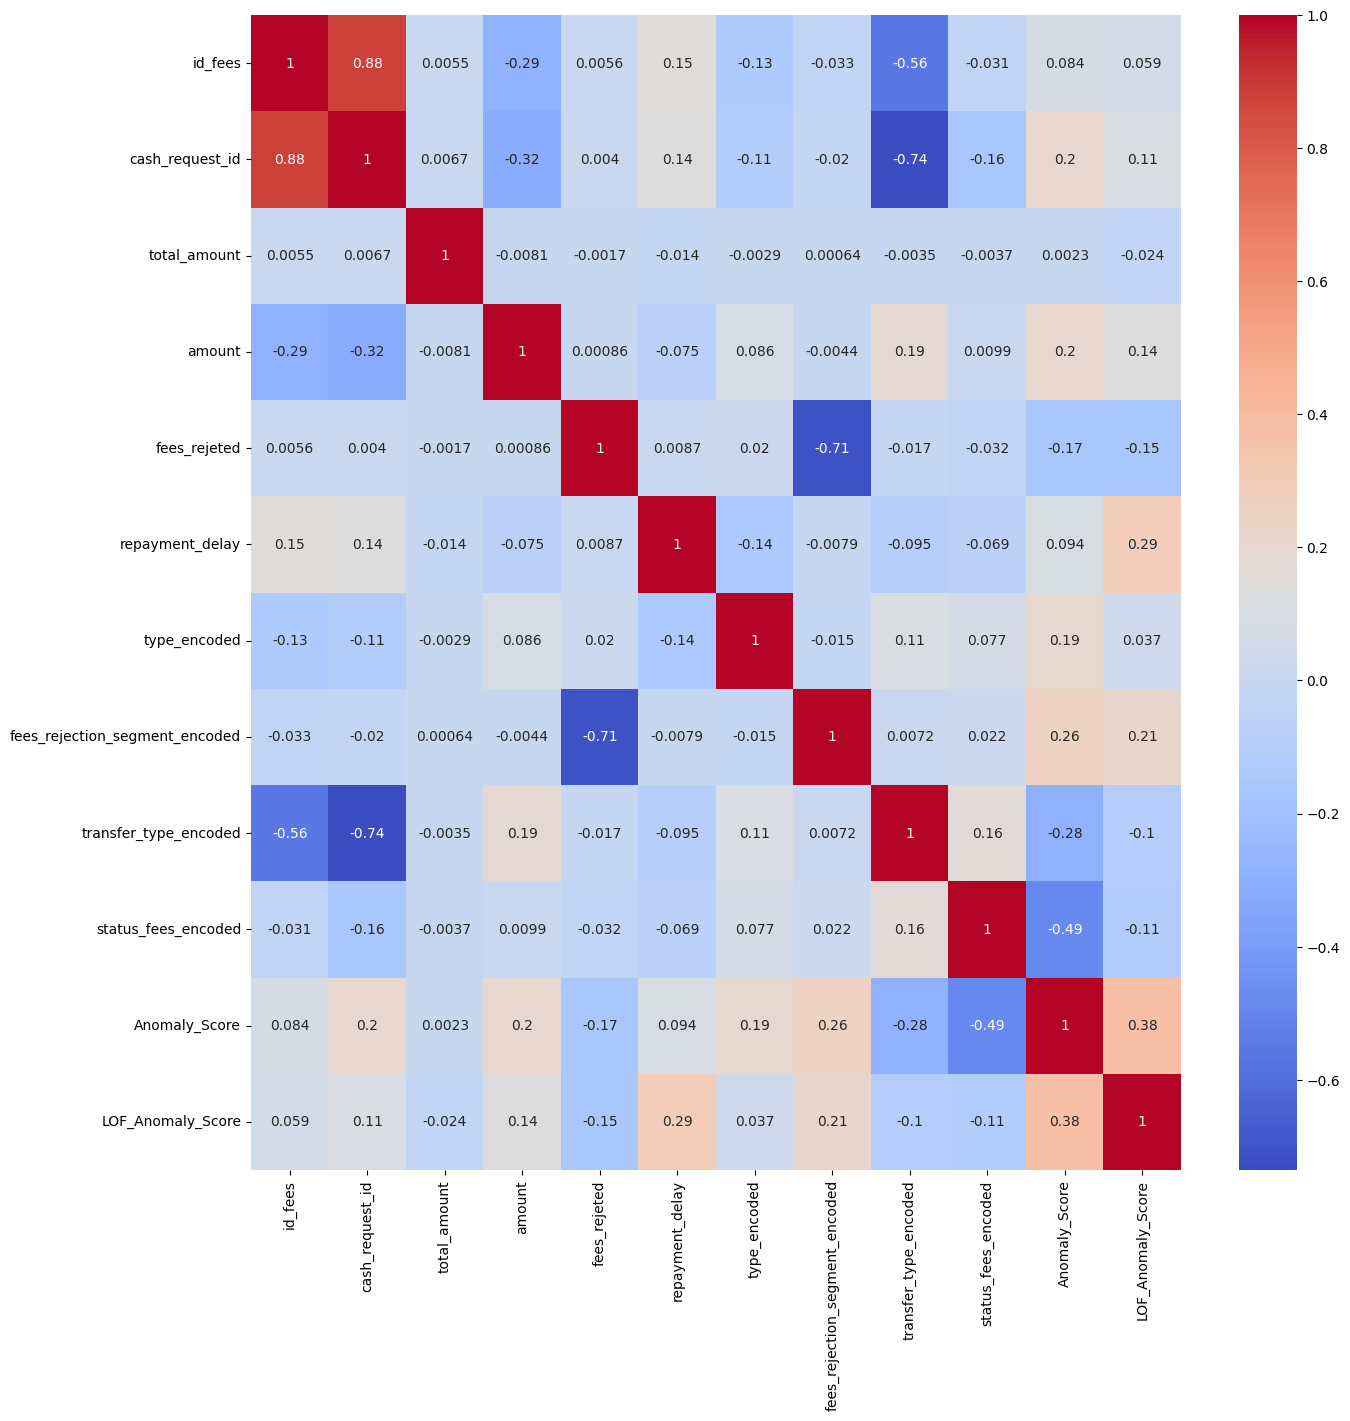

array([False])

In [68]:
corr_df= merged_df.drop(columns=['id_cash', 'deleted_account_id', 'user_id'])
totalS_nan= merged_df.total_amount.isna()
corr_matrix = corr_df[corr_df.describe().columns].corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()
totalS_nan.unique()

In [73]:
# Encode the Repayment_Status  and scale total amount
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder , StandardScaler

label_encoder = LabelEncoder() 
merged_df['Repayment_Status']= label_encoder.fit_transform(merged_df['Repayment_Status']) 
StandardScaler().fit_transform(merged_df['total_amount'].values.reshape(-1,1))

# Drop rows where 'Class' is NaN
merged_df = merged_df.dropna(subset=['Anomaly_Score'])
features_columns = ['total_amount', 'amount', 'repayment_delay' , 'type_encoded' , 'transfer_type_encoded' , 'status_fees_encoded', 'fees_rejection_segment_encoded']
from sklearn.model_selection import train_test_split
 
# Define features (X) and target (y)
X = merged_df[features_columns]
y = merged_df[target]
 
# Split the data into training and testing sets
X_interp, X_extrap, y_interap, y_extrap = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = False)
X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interap, test_size=0.2, random_state=42, shuffle = True)

In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

 
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, y_train)
 
# Make predictions
y_pred = model.predict(X_test)
y_pred_extrap = model.predict(X_extrap)
 
# Print classification report
print("Classification Report Test:")
print(classification_report(y_test, y_pred))

print("Classification Report Extrap:")
print(classification_report(y_extrap, y_pred_extrap))
# Print accuracy score
print("Accuracy Score Test: ", accuracy_score(y_test, y_pred))
print("Accuracy Score Extarp: ", accuracy_score(y_extrap, y_pred_extrap))

Classification Report Test:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99      3016
        True       0.99      0.86      0.92       353

    accuracy                           0.98      3369
   macro avg       0.99      0.93      0.96      3369
weighted avg       0.98      0.98      0.98      3369

Classification Report Extrap:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97      3108
        True       0.97      0.88      0.92      1104

    accuracy                           0.96      4212
   macro avg       0.96      0.93      0.95      4212
weighted avg       0.96      0.96      0.96      4212

Accuracy Score Test:  0.9845651528643514
Accuracy Score Extarp:  0.9605887939221273


In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Select features and target variable

features_columns = ['total_amount', 'amount', 'repayment_delay' , 'type_encoded' , 'transfer_type_encoded' , 'status_fees_encoded', 'fees_rejection_segment_encoded'] 
X = merged_df[features_columns].values  # Convert DataFrame to NumPy array
y = merged_df["Repayment_Status"].apply(lambda x: 1 if x == "Defaulter" else 0).values  # Convert labels

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape for CNN input (CNN expects 3D input: samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into training and testing data
X_interp, X_extrap, y_interp, y_extrap = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = False)
X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=0.2, random_state=42, shuffle = True)
print(f'X_interp.shape={X_interp.shape}, y_interp.shape={y_interp.shape}')
print(f'X_extrap.shape={X_extrap.shape}, y_extrap.shape={y_extrap.shape}')

X_interp.shape=(16845, 7, 1), y_interp.shape=(16845,)
X_extrap.shape=(4212, 7, 1), y_extrap.shape=(4212,)


In [77]:
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X.shape[1], 1)),
    Dropout(0.3),
    Conv1D(filters=32, kernel_size=1, activation='relu'),
    Conv1D(filters=32, kernel_size=1, activation='relu'),
    Dropout(0.3),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - loss: 0.0731 - val_accuracy: 1.0000 - val_loss: 6.1227e-06
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 4.9932e-06 - val_accuracy: 1.0000 - val_loss: 8.2903e-07
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 9.4517e-07 - val_accuracy: 1.0000 - val_loss: 2.6789e-07
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 3.5147e-07 - val_accuracy: 1.0000 - val_loss: 1.2398e-07
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.7742e-07 - val_accuracy: 1.0000 - val_loss: 6.7437e-08


In [78]:
cnn_model.fit(X_extrap, y_extrap, epochs=5, batch_size=32, validation_data=(X_interp, y_interp) )

Epoch 1/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 1.0969e-07 - val_accuracy: 1.0000 - val_loss: 5.5968e-08
Epoch 2/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 8.6135e-08 - val_accuracy: 1.0000 - val_loss: 4.9105e-08
Epoch 3/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 8.4189e-08 - val_accuracy: 1.0000 - val_loss: 4.3006e-08
Epoch 4/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 8.9359e-08 - val_accuracy: 1.0000 - val_loss: 3.7474e-08
Epoch 5/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 6.0207e-08 - val_accuracy: 1.0000 - val_loss: 3.3365e-08


In [100]:
import numpy as np

def predict_anomaly(client_data, model, threshold=0.5):
    """
    Predicts whether a given client's data is an anomaly using a trained classification model.

    Parameters:
    - client_data: A 1D array or list containing the client's input features.
    - model: The trained classification model (Random Forest, CNN, SVM, etc.).
    - threshold: Decision threshold for classification (default is 0.5 for binary classification).

    Returns:
    - "Anomaly" if the predicted probability >= threshold, else "Normal"
    - Probability score (or decision function if probability is not available)
    """
    # Ensure input is a NumPy array and reshape for models that expect batch input
    client_data = np.array(client_data).reshape(1, -1)  # Standard for most models

    # Try different prediction methods based on model type
    if hasattr(model, "predict_proba"):  
        # Models like RandomForest, LogisticRegression, XGBoost, etc.
        prediction_proba = model.predict_proba(client_data)[:, 1]  # Probability of class 1 (Anomaly)
    elif hasattr(model, "decision_function"):  
        # Models like SVM with linear kernel (does not provide probabilities)
        prediction_proba = model.decision_function(client_data)
    else:  
        # Models like Neural Networks (CNNs, MLPs) that use `.predict()`
        prediction_raw = model.predict(client_data)
        prediction_proba = prediction_raw if prediction_raw.ndim == 1 else prediction_raw[:, 0]  # Handle different output shapes

    # Convert probability to class label
    result = "Anomaly" if prediction_proba >= threshold else "Normal"

    return result, float(prediction_proba[0])  # Return label and probability score

In [106]:
def predict_anomaly_cnn(client_data, model, threshold=0.5):
    """
    Predicts whether a given client's data is an anomaly using the trained CNN model.

    Parameters:
    - client_data: A 1D array or list containing the client's input features.
    - model: The trained CNN model.
    - threshold: Decision threshold for classification (default is 0.5 for binary classification).

    Returns:
    - "Anomaly" if the predicted probability >= threshold, else "Normal"
    """
    # Ensure input is a NumPy array
    client_data = np.array(client_data).reshape(1, -1 , 1)  # Reshape for CNN (batch_size, features, channels)

    # Make Probability prediction
    prediction = model.predict(client_data)
    
    # Convert probability to class label
    result = "Anomaly" if prediction >= threshold else "Normal"

    return result, float(prediction)  # Return label and probability score


In [113]:
random_client_row = np.random.randint(1, len(X_extrap))

In [114]:
client_data = X_extrap[random_client_row,:]
result , prediction = predict_anomaly_cnn(client_data, cnn_model, threshold=0.5)
print(result , prediction )
print(y_extrap.iloc[random_client_row])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Normal 2.453682060050283e-13
True


In [89]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [90]:
smote= SMOTE(random_state=42)
X , y= smote.fit_resample(merged_df[features_columns], merged_df['Combined_Anomaly'])

scaler = StandardScaler()
X = scaler.fit_transform(X)


X_interp, X_extrap , y_interp, y_extrap = train_test_split(X, y, test_size=0.2 , shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp , test_size=0.2 , shuffle= True)
# Create a pipeline with SMOTE and Random Forest
pipeline = RandomForestClassifier(class_weight='balanced', random_state=42)

# Set up Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold CV

# Evaluate the model using cross-validation
cv_scores = cross_val_score(
    pipeline, X_train, y_train, cv=skf, scoring='roc_auc'  # Use ROC-AUC as the evaluation metric
)

# Print cross-validation results
print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Mean ROC-AUC: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

# Train the final model on the entire dataset (optional)
pipeline.fit(X_train, y_train)


Cross-Validation ROC-AUC Scores: [0.99940872 0.99938287 0.99998722 0.99949462 0.99980317]
Mean ROC-AUC: 0.9996 (±0.0002)


RandomForestClassifier(class_weight='balanced', random_state=42)

Test Accuracy: 0.9985
Extrapolation Accuracy: 0.9971


<Axes: >

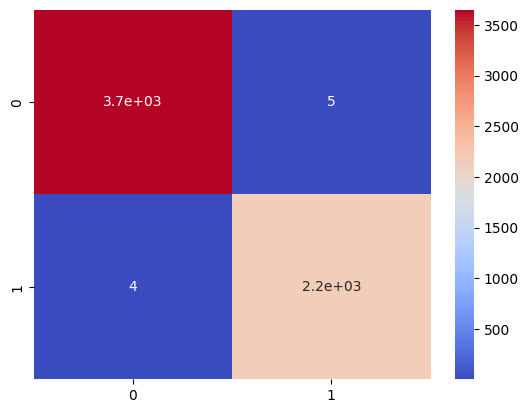

In [129]:
from sklearn.metrics import classification_report, confusion_matrix
# Predict on test data
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_extrap= pipeline.predict(X_extrap)
accuracy_extrap= accuracy_score(y_extrap,y_pred_extrap)
print(f'Extrapolation Accuracy: {accuracy_extrap:.4f}')
cm_random_forest =  confusion_matrix(y_test, y_pred)

labels = ['Normal', 'Anomaly']
sns.heatmap(data = cm_random_forest , annot=True, cmap='coolwarm', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.show

In [124]:
random_client_row = np.random.randint(1, len(X_extrap))

client_data = X_extrap[random_client_row,:]
result , prediction = predict_anomaly_cnn(client_data, cnn_model, threshold=0.5)
print(result , prediction )
print(y_extrap.iloc[random_client_row])

predict_anomaly(client_data, pipeline)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Normal 2.453682060050283e-13
True


('Anomaly', 1.0)